# Lab Two: Classification

We will build upon the predictive analysis (classification) that we completed in the
previous mini-project, adding additional modeling from new classification algorithms as well as
more explanations that are inline with the CRISP-DM framework.

We chose to continue to use the CIFAR-10 dataset. We identified the two tasks from the dataset to classify. 
Task 1: Cats and dogs
Task 2: Birds and airplanes


By Martin Garcia, Joanna Duran, Daniel Byrne

## Packages

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import random
import time
import sklearn.naive_bayes as b
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.utils import compute_class_weight

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Summary of Minilab

### Business Understanding
Our objective was to create a logistic regression model and a support vector machine model for the classification of each image. We were to determine which model is best suited for this standard classification task based on a comparison on their prediction accuracy, training times, and computational efficiency.

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6,000 images per class.

### Data Meaning Type

#### The CIFAR-10 dataset
We are using the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset which consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. The dataset includes are 50,000(80%) training images and 10,000(20%) test images broken in to 5 pre-randomized training batches and 1 test batch.

Each training batch contains 10,000 observations with a row vector of length 3,072 representative of color image of 32x32 pixels. The first 1,024 columns consist of red values, followed by green, and blue. The data also incorporates labels ranging from 0 to 9 and are listed below.

* airplane : 0
* automobile : 1
* bird : 2
* cat : 3
* deer : 4
* dog : 5
* frog : 6
* horse : 7
* ship : 8
* truck : 9

The test batch contains 1,000 randomly-selected images from each class. The 5 training batches are randomized and contain a variable number of images from each class. 

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

#### Simple Statistics

In [29]:
#load the data, reshape to 32x32 matrix per color, transpose matrices
def load_cfar10_batch(path, batch_id = None, reshape = True):
    """
    Argument:
    path -- path the datasets
    batch_id -- id of the batch (1 to 5) to load
    
    Returns:
    parameters -- python dictionary containing:
                    X -- features
                    Y -- labels
    """
    if batch_id is not None:
        filepath = path + 'data_batch_' + str(batch_id)
    else:
        filepath = path
        
    with open(filepath, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
    
    if reshape:    
        X = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        Y = np.array(batch['labels'])
    else:
        X = batch['data']
        Y = np.array(batch['labels'])
        
    return X, Y

In [30]:
def load_cfar10_dataset():
    """
    Loads the cfar10 dataset
    
    Arguments: 
        None
    
    Returns:
        X - Training dataset
        Y - Training labels
         - Test datset
        y_test - test labelss
    """
    x_test,y_test = load_cfar10_batch("data/test_batch",None,False)
    X,Y = load_cfar10_batch("data/",1,False)

    for n in range(2,6):
        x,y = load_cfar10_batch("data/",n,False)    
        X = np.concatenate((X,x),axis=0)
        Y = np.concatenate((Y,y),axis=0)


    return (X,Y,x_test,y_test)


Stats of batch #1:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 1005
Label Counts of [1](AUTOMOBILE) : 974
Label Counts of [2](BIRD) : 1032
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 999
Label Counts of [5](DOG) : 937
Label Counts of [6](FROG) : 1030
Label Counts of [7](HORSE) : 1001
Label Counts of [8](SHIP) : 1025
Label Counts of [9](TRUCK) : 981

Example of Image 5803:
Image - Min Value: 2 Max Value: 248
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


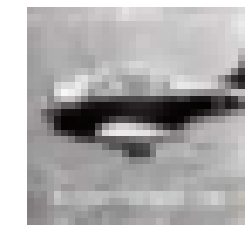

In [31]:
#load labels for our label
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#display images
def display_stats(data, batch_id, sample_id):
    features, labels = load_cfar10_batch(data, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))

    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)

batch_id = random.randint(1,5)
sample_id = random.randint(1,10000)
display_stats( "data/", batch_id, sample_id)

## Data Preparation Part 1

In this section we will define and prepare our class variables. 

Each of the batch files contains a dictionary with the following elements: 

data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image. 

labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries: 

label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

"Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis."

In [32]:
def simplify_labels(df,indexes,val = 10):
    """
    Return a modified label dataset filtered ot use only the classes specified

    Arguments:
    indees: indexes to filter
    df : label dataset
    val: new label value

    Returns:
    fdf - filtered df
      
    """

    def f(n):
        if n in indexes:
            return n
        else:
            return val
    
    return list(map(f,df))


In [33]:
#load the data
X,Y,x_test,y_test = load_cfar10_dataset()

# Simplify datasets to the classes we care about
Ycatdog = simplify_labels(Y,[3,5],10)
y_test_catdog =simplify_labels(y_test,[3,5],10)
Ybirdplane = simplify_labels(Y,[0,2],10)
y_test_birdplane = simplify_labels(y_test,[0,2],10)

## Data Preparation Part 2

The final training dataset is identical to the original.  However, we've created 4 new label datasets

- Ycatdog, y_test_catdog  : Cat and dog labels are retained, all others forced to next unused label
- Ybirdplane,y_test_birdplane : Bird and plane  labels are retained, all others forced to next unused label




## Modeling and Evaluation 1

"Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions."

## Modeling and Evaluation 2

 We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 


"Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time."

## Modeling and Evaluation 3

We identified the two tasks from the dataset to classify. For each task we will create three different classification/regression models

Task 1: Cats and dogs

    Model A: Naive Bayes
    Model B: KNN
    Model C: Logistic regression
    
Task 2: Birds and airplanes

    Model A: Naive Bayes
    Model B: Decision Tree
    Model C: SVM

"Create three different classiﬁcation/regression models (e.g., random forest, KNN, and SVM). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric"


### Task1 Model A
(Cats and Dogs- Naive Bayes)
    
We chose several implementations of the Naive Bayes classifier: GaussianNB, MultinomialNB, and BernoulliNB.


In [34]:
def buildmodel(nmodel,X,Y,x_test,y_test,**modelargs):
    """
    Builds one of a subset of sklearn models and returns a score
    
    Arguments:
    modeltype -- One of either "multi", "gauss", "bernoulli", "c", "nn" 
    
    """



    if nmodel == 'multi':
        m = b.MultinomialNB(**modelargs)
    elif nmodel == 'gauss':
        m = b.GaussianNB(**modelargs)
    elif nmodel == 'bernoulli':
        m = b.BernoulliNB(**modelargs)
    elif nmodel == "mlp":
        m = MLPClassifier(**modelargs)
    elif nmodel == "svm":
        m = SGDClassifier(**modelargs)
    elif nmodel == "BernoulliRBM":
        m = BernoulliRBM(**modelargs)
    elif nmodel == "LogisticRegression":
        m = LogisticRegression(**modelargs)
    
    m.fit(X, Y)
    score = m.score(x_test,y_test) * 100

    return m,score

In [35]:
multiNB,multiNBScore = buildmodel('multi',X,Ycatdog,x_test,y_test_catdog, alpha = .01)
print("MultinomialNB score :%",round(multiNBScore,2))

MultinomialNB score :% 54.28


In [36]:
gaussNB, gaussNBScore = buildmodel('gauss',X,Ycatdog,x_test,y_test_catdog,priors=None, var_smoothing=1e-09)
print("GaussianNB score :%",round(gaussNBScore,2))

GaussianNB score :% 54.31


In [37]:
berboulliNB, bernoulliNBScore = buildmodel('bernoulli',X,Ycatdog,x_test,y_test_catdog,alpha = .01)
print("BernoulliNB score :%",round(bernoulliNBScore,2))

BernoulliNB score :% 77.17


In [38]:
mlp, mlpScore = buildmodel('mlp',X,Ycatdog,x_test,y_test_catdog,
                           activation = 'relu',hidden_layer_sizes=(10,),learning_rate ='adaptive',verbose = True)
print("Multi-layer Perceptron score :%",round(mlpScore,2))

Iteration 1, loss = 1.74365571
Iteration 2, loss = 1.19322324
Iteration 3, loss = 0.99699987
Iteration 4, loss = 0.86001320
Iteration 5, loss = 0.77017326
Iteration 6, loss = 0.71417839
Iteration 7, loss = 0.68067276
Iteration 8, loss = 0.66131886
Iteration 9, loss = 0.65056431
Iteration 10, loss = 0.64479932
Iteration 11, loss = 0.64182117
Iteration 12, loss = 0.64033861
Iteration 13, loss = 0.63963023
Iteration 14, loss = 0.63931121
Iteration 15, loss = 0.63915374
Iteration 16, loss = 0.63909242
Iteration 17, loss = 0.63906594
Iteration 18, loss = 0.63906039
Iteration 19, loss = 0.63905525
Iteration 20, loss = 0.63904851
Iteration 21, loss = 0.63905847
Iteration 22, loss = 0.63905101
Iteration 23, loss = 0.63905057
Iteration 24, loss = 0.63905968
Iteration 25, loss = 0.63906806
Iteration 26, loss = 0.63905437
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Multi-layer Perceptron score :% 80.0


### Task1 Model B
(Cats and Dogs- KNN)

### Task1 Model C
(Cats and Dogs- Logistic Regression)

### Task2 Model A
(Birds and Airplanes- Naive Bayes)

### Task2 Model B
(Birds and Airplanes- Decision Tree)

### Task2 Model C
(Birds and Airplanes- SVM)

## Modeling and Evaluation 4

"Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model."

## Modeling and Evaluation 5

Advantages of Task 1: Cats and dogs Model A: Random Forest

    *
Advantages of Task 1: Cats and dogsModel B: KNN

    *
Advantages of Task 1: Cats and dogsModel C: Logistic regression

    *
Advantages of Task 2: Birds and airplanes Model A: Naive Bayes

    *
Advantages of Task 2: Birds and airplanes Model B: Decision Tree

    *
Advantages of Task 2: Birds and airplanes Model C: SVM

    *

"Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course."

## Modeling and Evaluation 6

 Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classiﬁcation task. Attributes are pixel representative of colors red green and blue  

In [39]:
np.min(X),np.max(X)

(0, 255)

In [40]:

scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X)
# Apply transform to both the training set and the test set.
X_trans = scaler.transform(X)

C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Martin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [41]:
np.min(X_trans),np.max(X_trans)

(-2.207429023795172, 2.625075032925612)

In [42]:
X_trans.shape


(50000, 3072)

In [ ]:
pca_cifar = PCA(n_components=2)
principalComponents_cifar = pca_cifar.fit_transform(X_trans)

In [ ]:
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar
             , columns = ['prin 1', 'prin 2'])
principal_cifar_Df['y'] = Y

In [ ]:
principal_cifar_Df.head()

,prin 1,prin 2,y
0,-22.055738,12.284905,6
1,4.013549,-5.049156,9
2,21.112303,-47.687196,9
3,-39.231269,2.334024,4
4,-15.571606,-16.687924,1


In [ ]:
print('Explained variation per principal component: {}'.format(pca_cifar.explained_variance_ratio_))

Explained variation per principal component: [0.26920197 0.11370504]


In [ ]:
feat_cols = ['pixel '+str(i) for i in range(X_trans.shape[1])]

In [ ]:
df_cifar = pd.DataFrame(X_trans,columns=feat_cols)

In [ ]:
df_cifar['label'] = Y

In [ ]:
df_cifar.head()

,pixel 0,pixel 1,pixel 2,pixel 3,pixel 4,pixel 5,pixel 6,pixel 7,pixel 8,pixel 9,...,pixel 3063,pixel 3064,pixel 3065,pixel 3066,pixel 3067,pixel 3068,pixel 3069,pixel 3070,pixel 3071,label
0,-0.976824,-1.202901,-1.121963,-0.882707,-0.476682,-0.193632,0.078882,0.155850,0.204232,0.198033,...,-0.865899,-0.756391,-0.850582,-1.051334,-0.881469,-0.152580,0.403264,-0.458600,-0.641402,6
1,0.317240,-0.057154,-0.360611,-0.410588,-0.100186,0.309605,0.541372,0.646868,0.105739,-0.336909,...,-1.114559,-0.725351,-0.198420,0.126923,0.296631,0.341717,0.387855,0.430806,0.448238,9
2,1.693034,1.695976,1.688121,1.686173,1.684686,1.679530,1.676576,1.670991,1.667558,1.662084,...,-0.477368,-0.523585,-0.695305,-0.741266,-0.648949,-0.538751,-0.475092,-0.473935,-0.459796,9
3,-1.399097,-1.285726,-1.288077,-1.243738,-1.229675,-1.297959,-1.308589,-1.541668,-1.442010,-1.294174,...,-1.161182,-0.849514,-1.114552,-1.082341,-1.020981,-1.172070,-1.322628,-1.179326,-1.034884,4
4,0.535188,0.522621,0.636070,0.714164,0.680696,0.617139,0.667506,0.702984,0.767049,0.761129,...,-0.399662,-0.445984,-0.493446,-0.477709,-0.540440,-0.554197,-0.490501,-0.550608,-0.520331,1


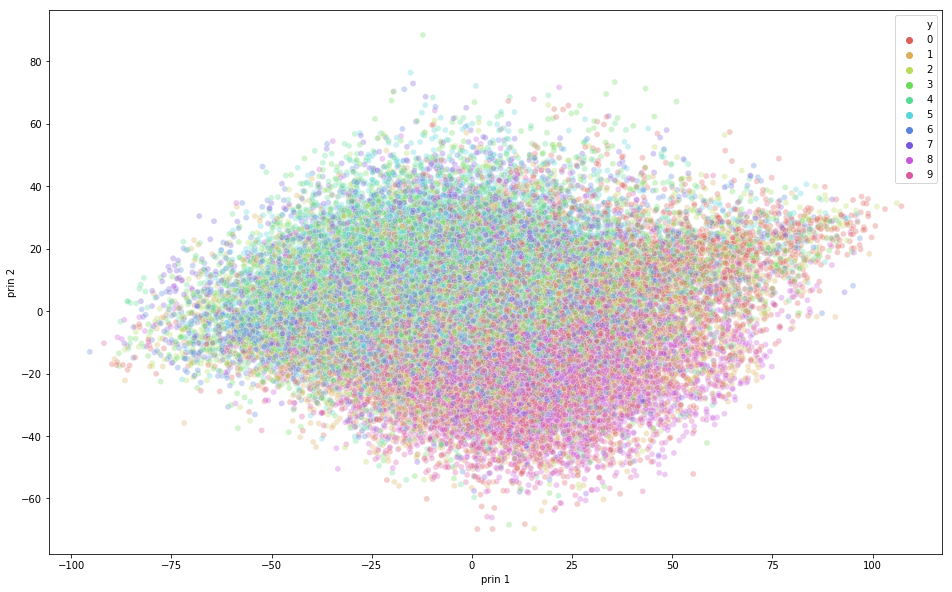

In [ ]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="prin 1", y="prin 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=principal_cifar_Df,
    legend="full",
    alpha=0.3
)

## Deployment

We believe that our model would be best suited for

"How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?"

#### OLD- MAY DELETE -Create Models

In this section we will create a logistic regression model and a support vector machine model for the classification task involved with your dataset.  We will assess how well each model performs (use 80/20 training/testing split)and adjust parameters of the models to make them more accurate. 

One of our primary concerns was that single level logistic regression cannot handle a multiclass problem very well.  In order to tackle this issue we decided to change to simplify the problem to a binary classification exercise. We modified the training labels to be either the "CAT"/"NOT CAT" which simplified the task for our models.

#### OLD- MAY DELETE -Logistic Regression Model

In [ ]:
# Build Logistic Regression Model with Stochastic Gradient Descent 
X,Y = load_cfar10_batch("data/",1,False)

for n in range(2,6):
    x,y = load_cfar10_batch("data/",n,False)    
    X = np.concatenate((X,x),axis=0)
    Y = np.concatenate((Y,y),axis=0)

test_X,test_Y = load_cfar10_batch("data/test_batch",None,False)

# Modify the dataset labels to lable cats/not/cats
#(if_test_is_false, if_test_is_true)[test]
catY = (Y == 3)
cat_test_Y = (test_Y == 3) 

sgdlr = SGDClassifier(alpha=0.001, max_iter=5000, tol=1e-3,verbose=1,n_jobs=4,loss="log")

print("Data shape: ",X.shape)
print("Labels shape: ",catY.shape)

print("Test Data shape: ",test_X.shape)
print("Test Labels shape: ",cat_test_Y.shape)


Data shape:  (50000, 3072)
Labels shape:  (50000,)
Test Data shape:  (10000, 3072)
Test Labels shape:  (10000,)


In [ ]:
import time

start = time.time()
sgdlr.fit(X,catY)
end = time.time()
elapsed = end - start
print("Training complete.  Time elapsed = ",elapsed)

-- Epoch 1
Norm: 1967.42, NNZs: 3072, Bias: -0.727642, T: 50000, Avg. loss: 510783.709339
Total training time: 0.28 seconds.
-- Epoch 2
Norm: 1286.17, NNZs: 3072, Bias: -1.363582, T: 100000, Avg. loss: 62619.596362
Total training time: 0.57 seconds.
-- Epoch 3
Norm: 1010.80, NNZs: 3072, Bias: -1.724595, T: 150000, Avg. loss: 36351.180337
Total training time: 0.88 seconds.
-- Epoch 4
Norm: 838.42, NNZs: 3072, Bias: -2.087868, T: 200000, Avg. loss: 25910.048096
Total training time: 1.16 seconds.
-- Epoch 5
Norm: 749.59, NNZs: 3072, Bias: -2.512967, T: 250000, Avg. loss: 19813.126261
Total training time: 1.44 seconds.
-- Epoch 6
Norm: 659.65, NNZs: 3072, Bias: -2.816118, T: 300000, Avg. loss: 16159.382816
Total training time: 1.77 seconds.
-- Epoch 7
Norm: 618.85, NNZs: 3072, Bias: -3.034413, T: 350000, Avg. loss: 13661.835522
Total training time: 2.06 seconds.
-- Epoch 8
Norm: 585.35, NNZs: 3072, Bias: -3.268898, T: 400000, Avg. loss: 11972.202928
Total training time: 2.34 seconds.
-- Ep

Norm: 203.91, NNZs: 3072, Bias: -6.614258, T: 3350000, Avg. loss: 1302.799753
Total training time: 19.90 seconds.
-- Epoch 68
Norm: 202.12, NNZs: 3072, Bias: -6.635525, T: 3400000, Avg. loss: 1285.427954
Total training time: 20.20 seconds.
-- Epoch 69
Norm: 200.82, NNZs: 3072, Bias: -6.651834, T: 3450000, Avg. loss: 1267.344937
Total training time: 20.49 seconds.
-- Epoch 70
Norm: 199.21, NNZs: 3072, Bias: -6.677715, T: 3500000, Avg. loss: 1234.469975
Total training time: 20.79 seconds.
-- Epoch 71
Norm: 197.83, NNZs: 3072, Bias: -6.695362, T: 3550000, Avg. loss: 1234.479369
Total training time: 21.08 seconds.
-- Epoch 72
Norm: 196.63, NNZs: 3072, Bias: -6.719419, T: 3600000, Avg. loss: 1214.615523
Total training time: 21.36 seconds.
-- Epoch 73
Norm: 195.58, NNZs: 3072, Bias: -6.742123, T: 3650000, Avg. loss: 1202.051193
Total training time: 21.65 seconds.
-- Epoch 74
Norm: 194.49, NNZs: 3072, Bias: -6.757895, T: 3700000, Avg. loss: 1182.715661
Total training time: 21.94 seconds.
-- E

Norm: 144.57, NNZs: 3072, Bias: -7.699692, T: 6650000, Avg. loss: 651.344915
Total training time: 39.69 seconds.
-- Epoch 134
Norm: 143.95, NNZs: 3072, Bias: -7.713764, T: 6700000, Avg. loss: 649.321297
Total training time: 39.98 seconds.
-- Epoch 135
Norm: 143.53, NNZs: 3072, Bias: -7.721361, T: 6750000, Avg. loss: 649.337856
Total training time: 40.28 seconds.
-- Epoch 136
Norm: 143.03, NNZs: 3072, Bias: -7.732645, T: 6800000, Avg. loss: 635.358989
Total training time: 40.58 seconds.
-- Epoch 137
Norm: 142.39, NNZs: 3072, Bias: -7.745380, T: 6850000, Avg. loss: 632.537261
Total training time: 40.87 seconds.
-- Epoch 138
Norm: 141.93, NNZs: 3072, Bias: -7.754902, T: 6900000, Avg. loss: 633.934665
Total training time: 41.17 seconds.
-- Epoch 139
Norm: 141.45, NNZs: 3072, Bias: -7.767286, T: 6950000, Avg. loss: 616.758238
Total training time: 41.46 seconds.
-- Epoch 140
Norm: 141.08, NNZs: 3072, Bias: -7.778129, T: 7000000, Avg. loss: 621.374964
Total training time: 41.75 seconds.
-- Ep

Norm: 118.53, NNZs: 3072, Bias: -8.344979, T: 9950000, Avg. loss: 435.308726
Total training time: 60.70 seconds.
-- Epoch 200
Norm: 118.23, NNZs: 3072, Bias: -8.350669, T: 10000000, Avg. loss: 434.518696
Total training time: 61.12 seconds.
-- Epoch 201
Norm: 118.01, NNZs: 3072, Bias: -8.358809, T: 10050000, Avg. loss: 428.816910
Total training time: 61.46 seconds.
-- Epoch 202
Norm: 117.79, NNZs: 3072, Bias: -8.366961, T: 10100000, Avg. loss: 426.174661
Total training time: 61.78 seconds.
-- Epoch 203
Norm: 117.60, NNZs: 3072, Bias: -8.373560, T: 10150000, Avg. loss: 426.579866
Total training time: 62.10 seconds.
-- Epoch 204
Norm: 117.31, NNZs: 3072, Bias: -8.381726, T: 10200000, Avg. loss: 428.457096
Total training time: 62.46 seconds.
-- Epoch 205
Norm: 117.07, NNZs: 3072, Bias: -8.389628, T: 10250000, Avg. loss: 421.360887
Total training time: 62.88 seconds.
-- Epoch 206
Norm: 116.73, NNZs: 3072, Bias: -8.400243, T: 10300000, Avg. loss: 418.309793
Total training time: 63.29 seconds

Norm: 102.87, NNZs: 3072, Bias: -8.798671, T: 13200000, Avg. loss: 324.920611
Total training time: 81.10 seconds.
-- Epoch 265
Norm: 102.68, NNZs: 3072, Bias: -8.803644, T: 13250000, Avg. loss: 327.395019
Total training time: 81.41 seconds.
-- Epoch 266
Norm: 102.49, NNZs: 3072, Bias: -8.810008, T: 13300000, Avg. loss: 323.500858
Total training time: 81.72 seconds.
-- Epoch 267
Norm: 102.28, NNZs: 3072, Bias: -8.816087, T: 13350000, Avg. loss: 321.252775
Total training time: 82.03 seconds.
-- Epoch 268
Norm: 102.09, NNZs: 3072, Bias: -8.820498, T: 13400000, Avg. loss: 320.866987
Total training time: 82.34 seconds.
-- Epoch 269
Norm: 101.92, NNZs: 3072, Bias: -8.826885, T: 13450000, Avg. loss: 319.492459
Total training time: 82.64 seconds.
-- Epoch 270
Norm: 101.71, NNZs: 3072, Bias: -8.832514, T: 13500000, Avg. loss: 320.051729
Total training time: 82.95 seconds.
-- Epoch 271
Norm: 101.51, NNZs: 3072, Bias: -8.838556, T: 13550000, Avg. loss: 318.150387
Total training time: 83.25 second

In [ ]:
sgdlrscore = sgdlr.score(test_X,cat_test_Y)
print("Logistic Regression Accuracy: ",sgdlrscore)

Logistic Regression Accuracy:  0.8961


#### OLD- MAY DELETE -Support Vector Machine Model

In [ ]:
# Build SVM Regression Model with Stochastic Gradient Descent 
sgd_svm = SGDClassifier(alpha=0.001, max_iter=5000, verbose = 1, tol=1e-3,n_jobs=4)

In [ ]:
start = time.time()
sgd_svm.fit(X,catY)
end = time.time()

svm_elapsed = end - start
print("Training complete.  Time elapsed = ",svm_elapsed)

-- Epoch 1
Norm: 2045.53, NNZs: 3072, Bias: -0.224207, T: 50000, Avg. loss: 487764.876782
Total training time: 0.30 seconds.
-- Epoch 2
Norm: 1278.53, NNZs: 3072, Bias: -1.055224, T: 100000, Avg. loss: 61967.698595
Total training time: 0.60 seconds.
-- Epoch 3
Norm: 1001.65, NNZs: 3072, Bias: -1.786554, T: 150000, Avg. loss: 35767.969158
Total training time: 0.90 seconds.
-- Epoch 4
Norm: 860.63, NNZs: 3072, Bias: -2.022846, T: 200000, Avg. loss: 25667.640285
Total training time: 1.22 seconds.
-- Epoch 5
Norm: 756.40, NNZs: 3072, Bias: -2.244157, T: 250000, Avg. loss: 20009.614379
Total training time: 1.51 seconds.
-- Epoch 6
Norm: 673.41, NNZs: 3072, Bias: -2.587348, T: 300000, Avg. loss: 16021.693431
Total training time: 1.80 seconds.
-- Epoch 7
Norm: 624.05, NNZs: 3072, Bias: -2.813010, T: 350000, Avg. loss: 13695.286851
Total training time: 2.10 seconds.
-- Epoch 8
Norm: 579.91, NNZs: 3072, Bias: -3.003044, T: 400000, Avg. loss: 11887.103927
Total training time: 2.40 seconds.
-- Ep

Norm: 203.20, NNZs: 3072, Bias: -6.214154, T: 3350000, Avg. loss: 1302.887967
Total training time: 18.67 seconds.
-- Epoch 68
Norm: 201.24, NNZs: 3072, Bias: -6.236359, T: 3400000, Avg. loss: 1298.371996
Total training time: 18.93 seconds.
-- Epoch 69
Norm: 199.98, NNZs: 3072, Bias: -6.261455, T: 3450000, Avg. loss: 1265.557653
Total training time: 19.20 seconds.
-- Epoch 70
Norm: 198.56, NNZs: 3072, Bias: -6.285070, T: 3500000, Avg. loss: 1268.022785
Total training time: 19.47 seconds.
-- Epoch 71
Norm: 197.30, NNZs: 3072, Bias: -6.310056, T: 3550000, Avg. loss: 1226.924686
Total training time: 19.74 seconds.
-- Epoch 72
Norm: 195.73, NNZs: 3072, Bias: -6.330182, T: 3600000, Avg. loss: 1219.735874
Total training time: 20.01 seconds.
-- Epoch 73
Norm: 194.55, NNZs: 3072, Bias: -6.340408, T: 3650000, Avg. loss: 1193.396362
Total training time: 20.27 seconds.
-- Epoch 74
Norm: 193.08, NNZs: 3072, Bias: -6.367605, T: 3700000, Avg. loss: 1159.437515
Total training time: 20.54 seconds.
-- E

Norm: 144.62, NNZs: 3072, Bias: -7.296868, T: 6650000, Avg. loss: 657.000063
Total training time: 36.59 seconds.
-- Epoch 134
Norm: 144.20, NNZs: 3072, Bias: -7.306601, T: 6700000, Avg. loss: 650.488754
Total training time: 36.86 seconds.
-- Epoch 135
Norm: 143.76, NNZs: 3072, Bias: -7.314930, T: 6750000, Avg. loss: 639.944416
Total training time: 37.12 seconds.
-- Epoch 136
Norm: 143.12, NNZs: 3072, Bias: -7.330423, T: 6800000, Avg. loss: 645.704642
Total training time: 37.39 seconds.
-- Epoch 137
Norm: 142.46, NNZs: 3072, Bias: -7.340820, T: 6850000, Avg. loss: 635.091517
Total training time: 37.66 seconds.
-- Epoch 138
Norm: 142.07, NNZs: 3072, Bias: -7.350570, T: 6900000, Avg. loss: 626.895883
Total training time: 37.92 seconds.
-- Epoch 139
Norm: 141.51, NNZs: 3072, Bias: -7.363568, T: 6950000, Avg. loss: 622.655838
Total training time: 38.19 seconds.
-- Epoch 140
Norm: 141.10, NNZs: 3072, Bias: -7.375755, T: 7000000, Avg. loss: 623.692613
Total training time: 38.46 seconds.
-- Ep

Norm: 118.11, NNZs: 3072, Bias: -7.914785, T: 9950000, Avg. loss: 433.174076
Total training time: 54.53 seconds.
-- Epoch 200
Norm: 117.85, NNZs: 3072, Bias: -7.920797, T: 10000000, Avg. loss: 432.189659
Total training time: 54.80 seconds.
-- Epoch 201
Norm: 117.56, NNZs: 3072, Bias: -7.931274, T: 10050000, Avg. loss: 430.077379
Total training time: 55.08 seconds.
-- Epoch 202
Norm: 117.25, NNZs: 3072, Bias: -7.941597, T: 10100000, Avg. loss: 423.906421
Total training time: 55.36 seconds.
-- Epoch 203
Norm: 116.98, NNZs: 3072, Bias: -7.949003, T: 10150000, Avg. loss: 421.515940
Total training time: 55.67 seconds.
-- Epoch 204
Norm: 116.76, NNZs: 3072, Bias: -7.955489, T: 10200000, Avg. loss: 422.686089
Total training time: 55.97 seconds.
-- Epoch 205
Norm: 116.42, NNZs: 3072, Bias: -7.963806, T: 10250000, Avg. loss: 421.025539
Total training time: 56.27 seconds.
-- Epoch 206
Norm: 116.13, NNZs: 3072, Bias: -7.971104, T: 10300000, Avg. loss: 420.047843
Total training time: 56.58 seconds

Norm: 102.69, NNZs: 3072, Bias: -8.375060, T: 13200000, Avg. loss: 324.903145
Total training time: 72.69 seconds.
-- Epoch 265
Norm: 102.57, NNZs: 3072, Bias: -8.383981, T: 13250000, Avg. loss: 322.187850
Total training time: 72.96 seconds.
-- Epoch 266
Norm: 102.40, NNZs: 3072, Bias: -8.389180, T: 13300000, Avg. loss: 324.203820
Total training time: 73.23 seconds.
-- Epoch 267
Norm: 102.22, NNZs: 3072, Bias: -8.395710, T: 13350000, Avg. loss: 322.064459
Total training time: 73.50 seconds.
-- Epoch 268
Norm: 101.99, NNZs: 3072, Bias: -8.402738, T: 13400000, Avg. loss: 324.631830
Total training time: 73.78 seconds.
-- Epoch 269
Norm: 101.82, NNZs: 3072, Bias: -8.409515, T: 13450000, Avg. loss: 318.384437
Total training time: 74.04 seconds.
-- Epoch 270
Norm: 101.59, NNZs: 3072, Bias: -8.418642, T: 13500000, Avg. loss: 320.582853
Total training time: 74.34 seconds.
-- Epoch 271
Norm: 101.47, NNZs: 3072, Bias: -8.425147, T: 13550000, Avg. loss: 316.258528
Total training time: 74.60 second

Norm: 92.08, NNZs: 3072, Bias: -8.751171, T: 16450000, Avg. loss: 262.167956
Total training time: 90.30 seconds.
-- Epoch 330
Norm: 91.94, NNZs: 3072, Bias: -8.755540, T: 16500000, Avg. loss: 260.697189
Total training time: 90.57 seconds.
-- Epoch 331
Norm: 91.78, NNZs: 3072, Bias: -8.760080, T: 16550000, Avg. loss: 261.002780
Total training time: 90.84 seconds.
-- Epoch 332
Norm: 91.65, NNZs: 3072, Bias: -8.764725, T: 16600000, Avg. loss: 256.782037
Total training time: 91.11 seconds.
-- Epoch 333
Norm: 91.49, NNZs: 3072, Bias: -8.767914, T: 16650000, Avg. loss: 259.285396
Total training time: 91.38 seconds.
-- Epoch 334
Norm: 91.35, NNZs: 3072, Bias: -8.772110, T: 16700000, Avg. loss: 260.832735
Total training time: 91.65 seconds.
-- Epoch 335
Norm: 91.24, NNZs: 3072, Bias: -8.776715, T: 16750000, Avg. loss: 255.014602
Total training time: 91.92 seconds.
-- Epoch 336
Norm: 91.09, NNZs: 3072, Bias: -8.780471, T: 16800000, Avg. loss: 258.988277
Total training time: 92.19 seconds.
-- Ep

Norm: 84.14, NNZs: 3072, Bias: -9.048168, T: 19700000, Avg. loss: 216.578272
Total training time: 107.89 seconds.
-- Epoch 395
Norm: 84.02, NNZs: 3072, Bias: -9.052274, T: 19750000, Avg. loss: 216.148388
Total training time: 108.18 seconds.
-- Epoch 396
Norm: 83.89, NNZs: 3072, Bias: -9.057179, T: 19800000, Avg. loss: 218.196237
Total training time: 108.45 seconds.
-- Epoch 397
Norm: 83.77, NNZs: 3072, Bias: -9.061314, T: 19850000, Avg. loss: 215.566007
Total training time: 108.72 seconds.
-- Epoch 398
Norm: 83.67, NNZs: 3072, Bias: -9.065691, T: 19900000, Avg. loss: 215.784731
Total training time: 108.99 seconds.
-- Epoch 399
Norm: 83.58, NNZs: 3072, Bias: -9.070209, T: 19950000, Avg. loss: 214.736734
Total training time: 109.31 seconds.
-- Epoch 400
Norm: 83.49, NNZs: 3072, Bias: -9.075116, T: 20000000, Avg. loss: 215.860929
Total training time: 109.58 seconds.
-- Epoch 401
Norm: 83.38, NNZs: 3072, Bias: -9.079259, T: 20050000, Avg. loss: 214.090299
Total training time: 109.85 second

In [ ]:
sgd_svmscore = sgd_svm.score(test_X,cat_test_Y)
print("Support Vector Machine Model: ",sgd_svmscore)

Support Vector Machine Model:  0.5151


In [ ]:
#Weights
weights = sgd_svm.coef_
weights

array([[ 0.80131336,  0.00376525,  1.9414991 , ...,  0.59823444,
        -0.38909199,  2.97674688]])

#### OLD- MAY DELETE -Model Advantages

We will discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency?

In [ ]:

def print_mislabeled_images(X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = y == p
    mislabeled_indices = np.asarray(np.where(a == False))
    plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    
    print("There were "+str(num_images)+" mislabeled images.")
    print("Here is a sampling of 6 of the mislabeled images.")
    
    rand_ids = np.random.randint(num_images, size=6)
    for i in range(6):
        index = mislabeled_indices[0][i]
        plt.subplot(3, 2, i + 1)
        plt.imshow(X[index].reshape(3, 32, 32).transpose(1,2,0), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction:"+str(p[index]) + "\nLabel:"+str(y[index]))



####  OLD- MAY DELETE -Logistic Regression Mislabeled Images

There were 1039 mislabeled images.
Here is a sampling of 6 of the mislabeled images.


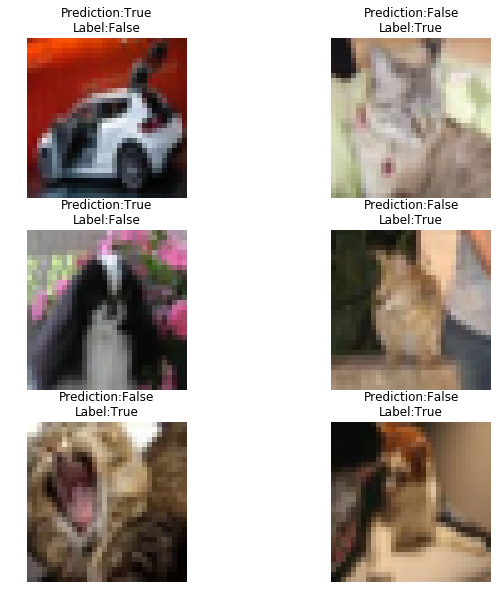

In [ ]:
sgdpred_test = sgdlr.predict(test_X)
print_mislabeled_images(test_X,cat_test_Y,sgdpred_test)

#### OLD- MAY DELETE -Support Vector Machine Mislabeled Images

There were 4849 mislabeled images.
Here is a sampling of 6 of the mislabeled images.


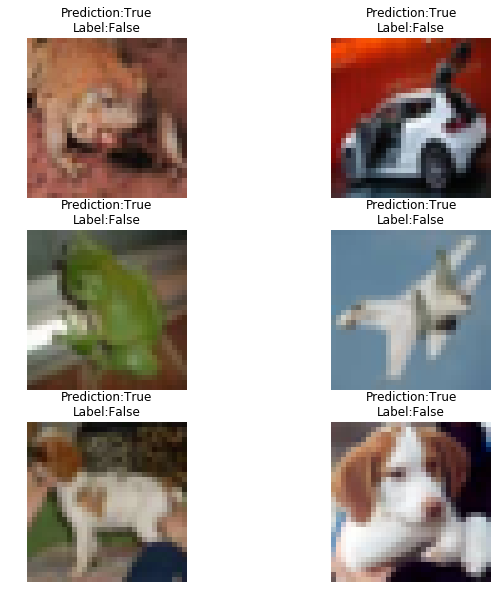

In [ ]:
svmpred_test = sgd_svm.predict(test_X)
print_mislabeled_images(test_X,cat_test_Y,svmpred_test)

#### OLD- MAY DELETE -Model Comparison

The two models were trained with similar hyperparameters to simplify the A/B comparison between the two models.  The only parameter that varied between the two models was the *loss* parameter. 

The loss function defaults to ‘hinge’, which gives a linear SVM. The ‘log’ loss gives logistic regression, a probabilistic classifier. 

The two models we cerated in identifying cats peformed similarly in terms of accuracy, 85% to 89% accuaracy over several test runs.

Training times varied depending on the underlying hardware and computer workload; however, the two models were comparable in overall training times on this dataset 69-72 seconds on Intel Core i7-6700 @ 3.4GHz, 24Gb of RAM, 4 Cores, and and NVIDIA 1060. 

Both models also seemed to mislabel similar images as evident in the plots above.  Both models seemed to struggle with cats in odd, off center poses, or curled up into a ball.  The one car image that was mislabaled as a cat kind of resemebles a cat with the openned hatchback of the car resembling a tail.

Overall both models performed similarily in this classification task with the chosen model parameters.

#### OLD- MAY DELETE -Interpreting Feature Importance

In this section we will use the weights from logistic regression to interpret the importance of different features for the classification task.

Individual weights represent the strength of connection between our units, in this case it is a connection from our array of pixels which come in three magnitudes of RBG colors. If the weights are overlayed as a matrix we can see the influence of specific colors to help us identify a class. The weights act as a filter coefficient for each pixel of our array of length. We define the score of each class in this case cat vs not cat based on the weighted sum of all the pixels with all images, each class sore is a linear function over this space.

In [ ]:
#Weights
print(X.shape)

weights = sgd_svm.coef_
print(weights.shape)
#plt.scatter(X,weights)

(50000, 3072)
(1, 3072)


#### OLD- MAY DELETE - Interpreting Support Vectors

In this section we will look at the chosen support vectors for the classification task. 

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X, catY) 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)